[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 67200, number of used features: 64
[LightGBM] [Info] Start training from score -2.351375
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -3.737670
[LightGBM] [Info] Start training from score -1.252763
[LightGBM] [Info] Start training from score -1.252763
[LightGBM] [Info] Start training from score -1.945910


c:\Users\aanaj\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:41:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Comparación de métricas:
           Logistic Regression  Random Forest  Decision Tree  \
Accuracy                 0.867          0.993          0.959   
Precision                0.865          0.993          0.959   
Recall                   0.867          0.993          0.959   
F1-score                 0.865          0.993          0.959   

           Gradient Boosting  LightGBM  XGBoost  Naive Bayes    SVM    KNN  
Accuracy               0.978     0.996    0.997        0.463  0.916  0.916  
Precision              0.978     0.996    0.997        0.761  0.921  0.916  
Recall                 0.978     0.996    0.997        0.463  0.916  0.916  
F1-score               0.978     0.996    0.997        0.548  0.914  0.915  

Tiempos de ejecución por modelo:
                Modelo  Tiempo (segundos)
7                  SVM        1359.806578
3    Gradient Boosting         929.222953
1        Random Forest          87.272784
5              XGBoost          10.200485
2        Decision Tree   

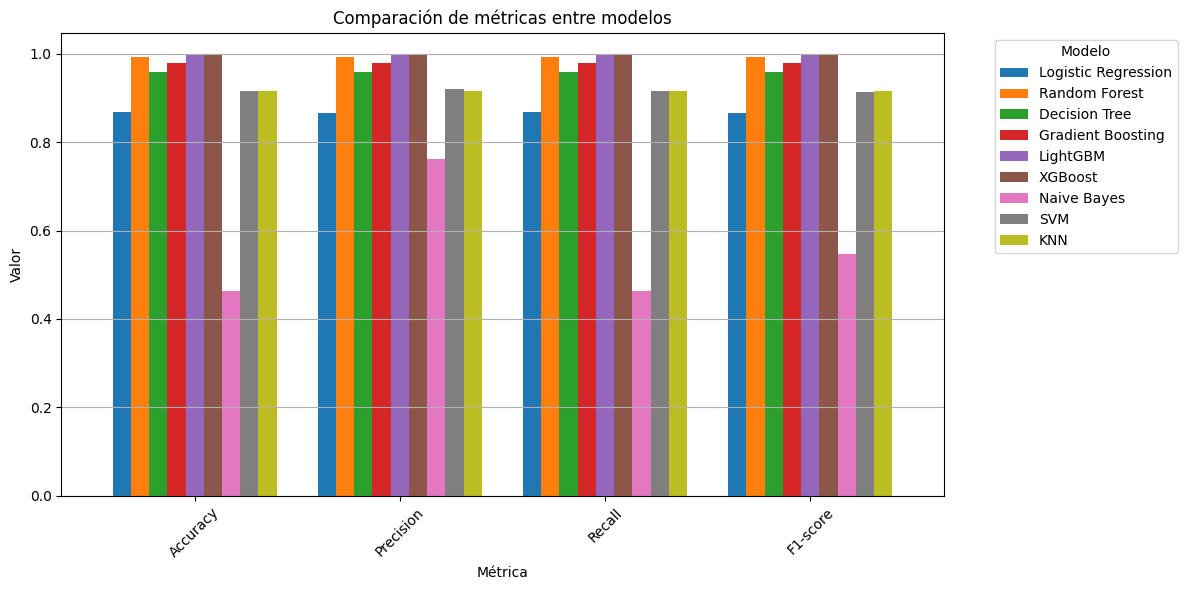

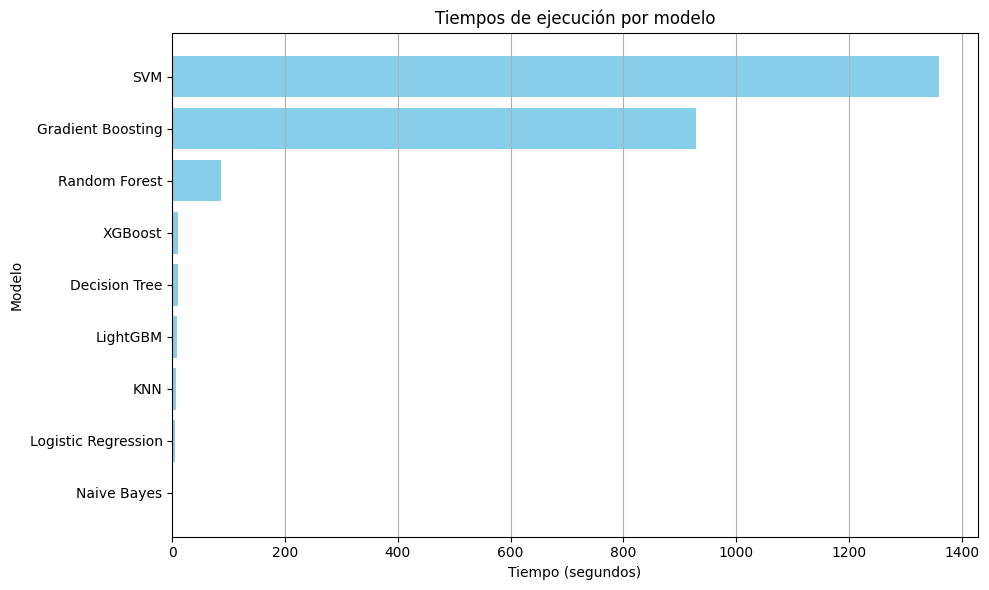

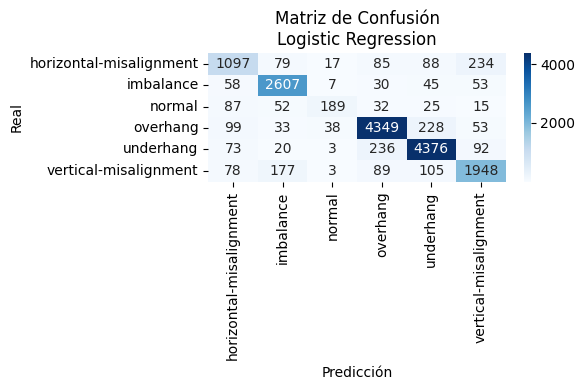

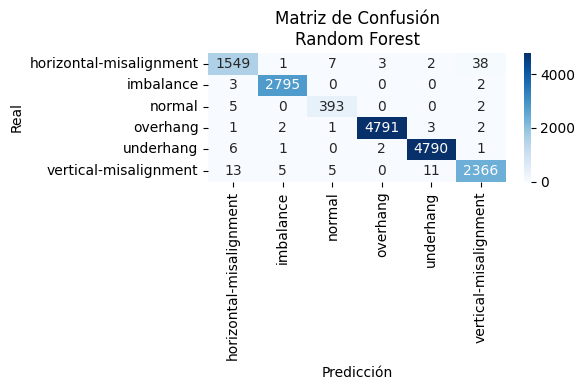

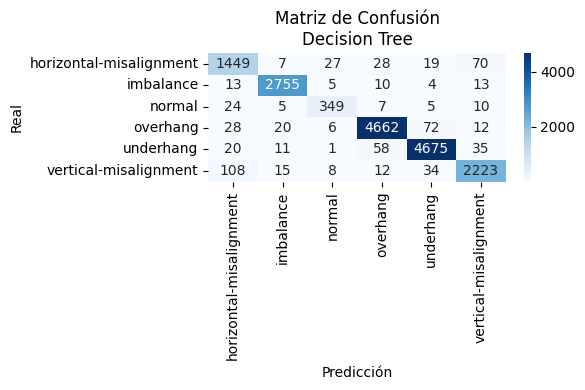

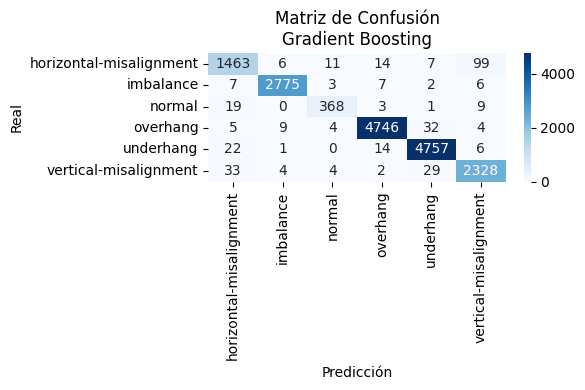

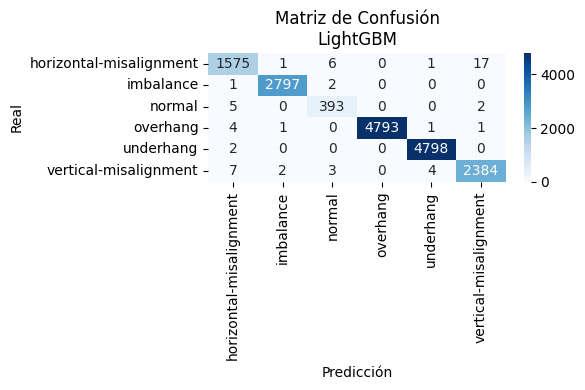

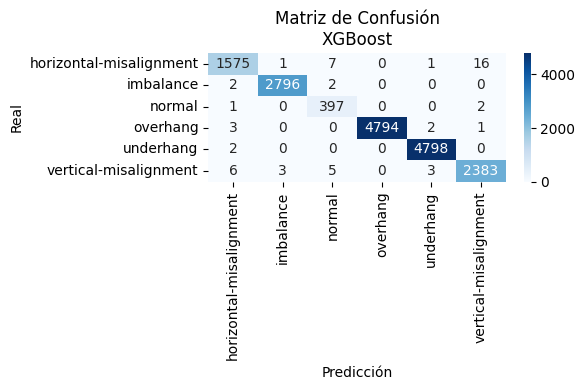

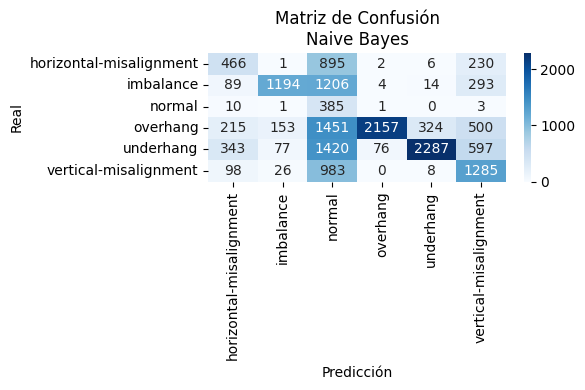

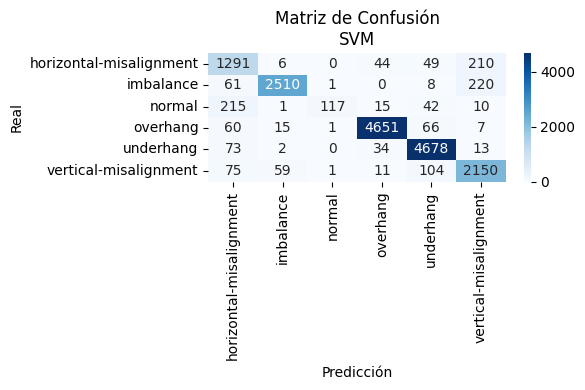

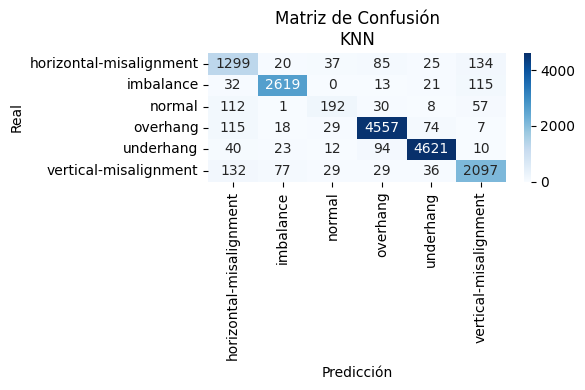

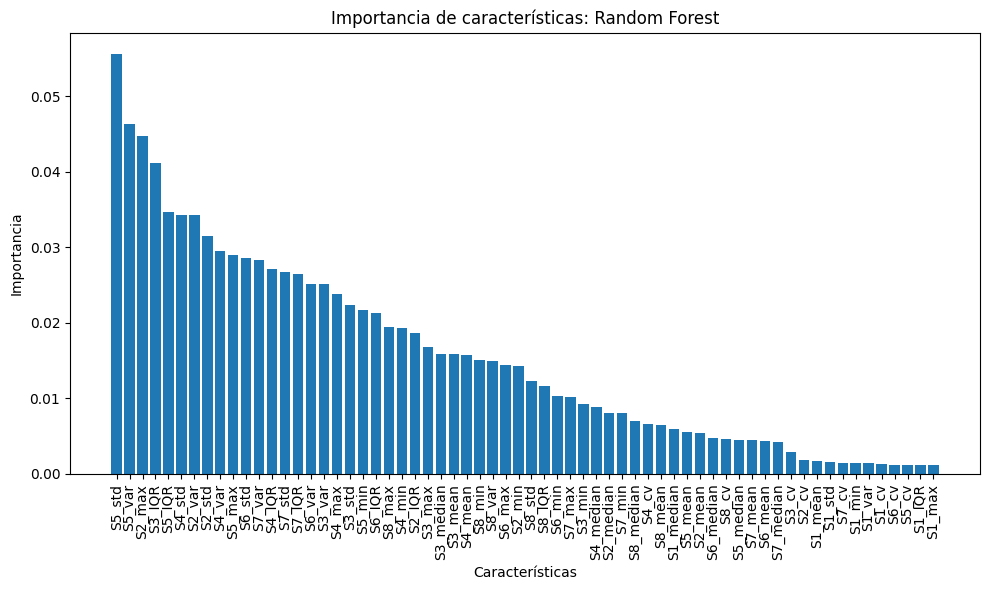

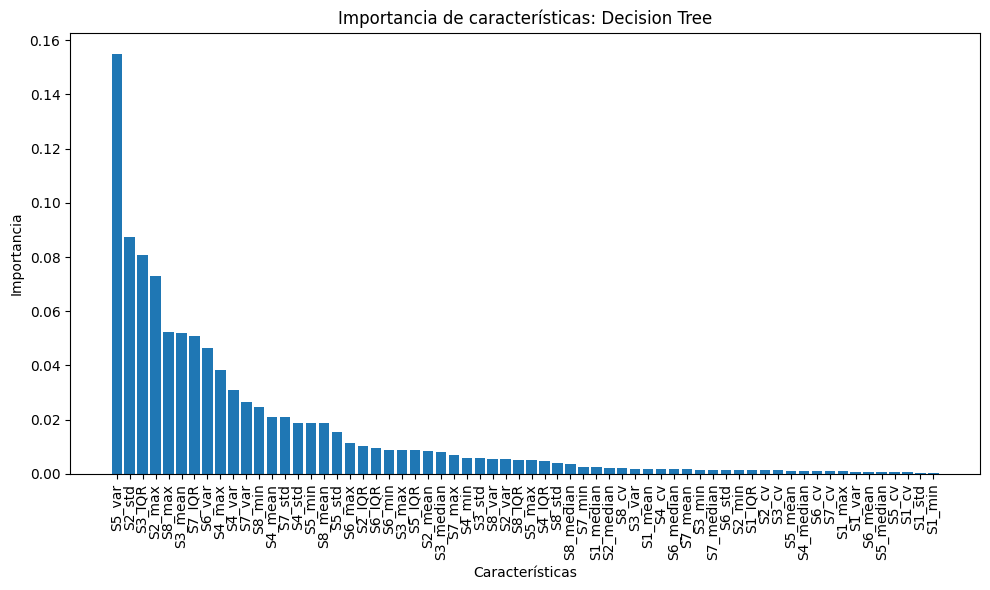

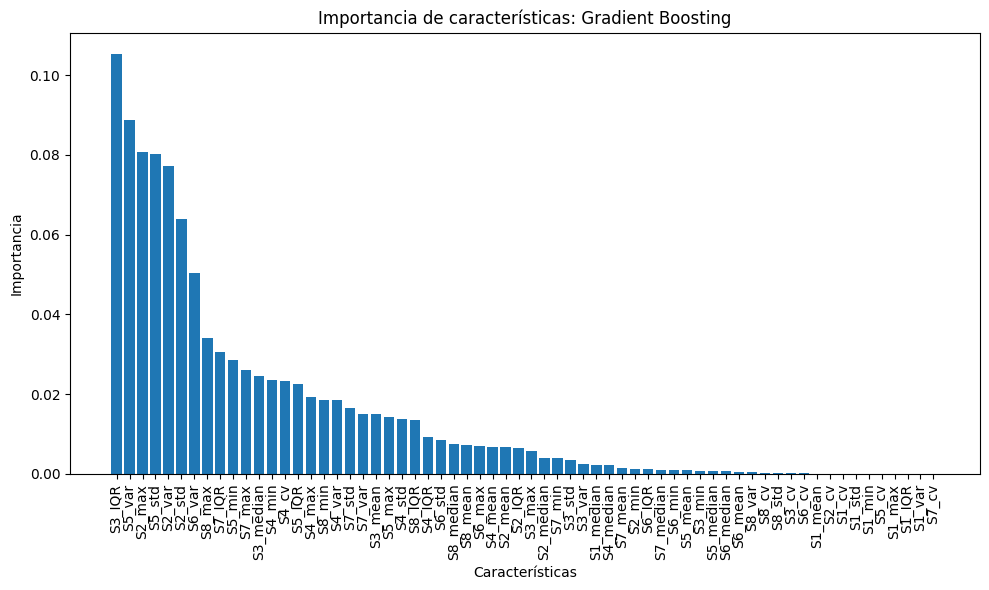

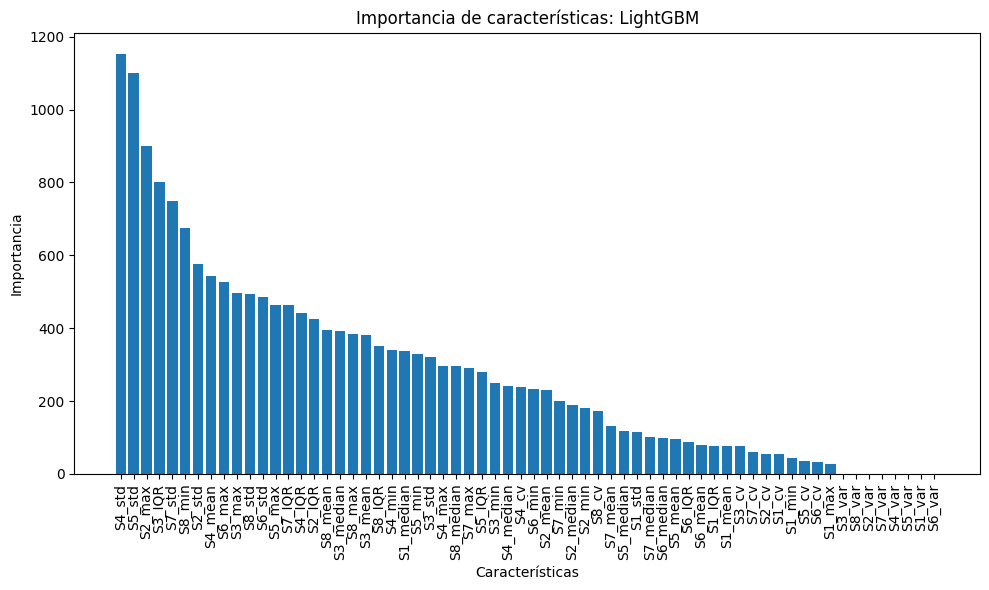

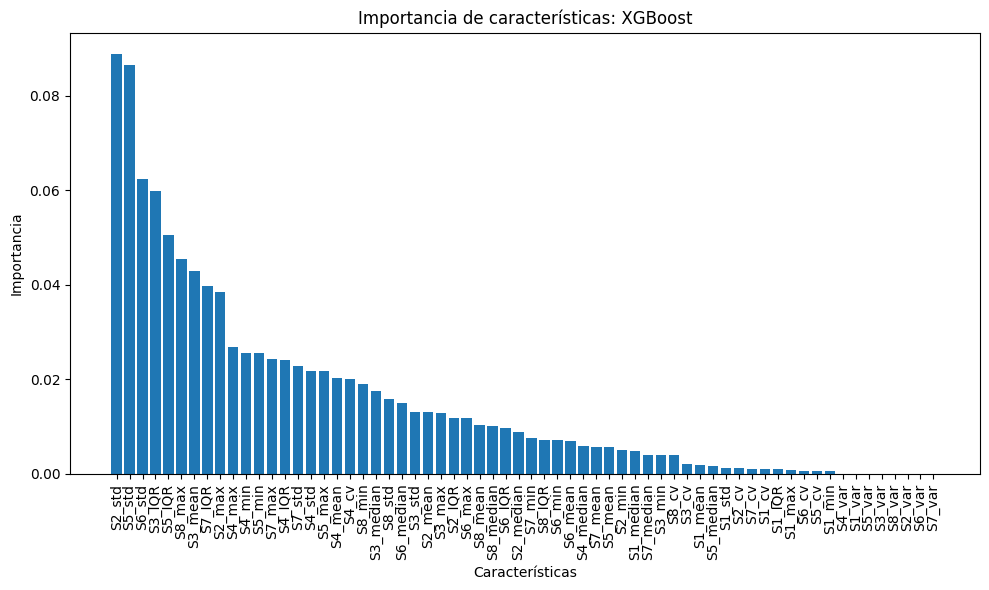

In [1]:
import pandas as pd
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el dataset
df = pd.read_csv("ultimate.csv")

# Separar características y etiquetas
X = df.drop(columns=["Hz", "medida", "Tipo"])
y = df["Tipo"]

# Codificar etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# División en entrenamiento y prueba con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Modelos con indicación de necesidad de escalado
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, random_state=42), True),
    'Random Forest': (RandomForestClassifier(n_estimators=100, random_state=42), False),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), False),
    'Gradient Boosting': (GradientBoostingClassifier(n_estimators=100, random_state=42), False),
    'LightGBM': (lgb.LGBMClassifier(n_estimators=100, random_state=42), False),
    'XGBoost': (xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss'), False),
    'Naive Bayes': (GaussianNB(), False),
    'SVM': (SVC(probability=True, random_state=42), True),
    'KNN': (KNeighborsClassifier(n_neighbors=5), True)
}

# Escalar características para los modelos que lo necesiten
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Diccionarios para almacenar métricas y tiempos de cada modelo
metrics_dict = {}
times_dict = {}

# Entrenamiento y evaluación de modelos
for model_name, (model, needs_scaling) in models.items():
    start_time = time.time()
    
    if needs_scaling:
        X_train_input, X_test_input = X_train_scaled, X_test_scaled
    else:
        X_train_input, X_test_input = X_train, X_test

    model.fit(X_train_input, y_train)
    y_pred = model.predict(X_test_input)
    y_prob = model.predict_proba(X_test_input) if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=1),
        'F1-score': f1_score(y_test, y_pred, average='weighted')
    }
    metrics_dict[model_name] = metrics
    times_dict[model_name] = time.time() - start_time

# Comparación de métricas
metrics_df = pd.DataFrame(metrics_dict).round(3)
print("Comparación de métricas:")
print(metrics_df)

# Tiempos de ejecución
times_df = pd.DataFrame(list(times_dict.items()), columns=['Modelo', 'Tiempo (segundos)'])
times_df = times_df.sort_values(by='Tiempo (segundos)', ascending=False)
print("\nTiempos de ejecución por modelo:")
print(times_df)

# Gráfica de métricas
metrics_df.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Comparación de métricas entre modelos')
plt.xlabel('Métrica')
plt.ylabel('Valor')
plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Gráfica de tiempos de ejecución
plt.figure(figsize=(10, 6))
plt.barh(times_df['Modelo'], times_df['Tiempo (segundos)'], color='skyblue')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Modelo')
plt.title('Tiempos de ejecución por modelo')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Matriz de confusión
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(title)
    plt.ylabel('Real')
    plt.xlabel('Predicción')
    plt.tight_layout()

for model_name, (model, needs_scaling) in models.items():
    if needs_scaling:
        X_test_input = X_test_scaled
    else:
        X_test_input = X_test

    y_pred = model.predict(X_test_input)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    plot_confusion_matrix(conf_matrix, f'Matriz de Confusión\n{model_name}')
    plt.show()

# Importancia de características para modelos basados en árboles
for model_name, (model, needs_scaling) in models.items():
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1]
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
        plt.xticks(range(len(sorted_idx)), X.columns[sorted_idx], rotation=90)
        plt.title(f'Importancia de características: {model_name}')
        plt.xlabel('Características')
        plt.ylabel('Importancia')
        plt.tight_layout()
        plt.show()
